In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
%precision 4
plt.style.use('ggplot')

In [2]:
# from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(1234)

### Аналитическое решение

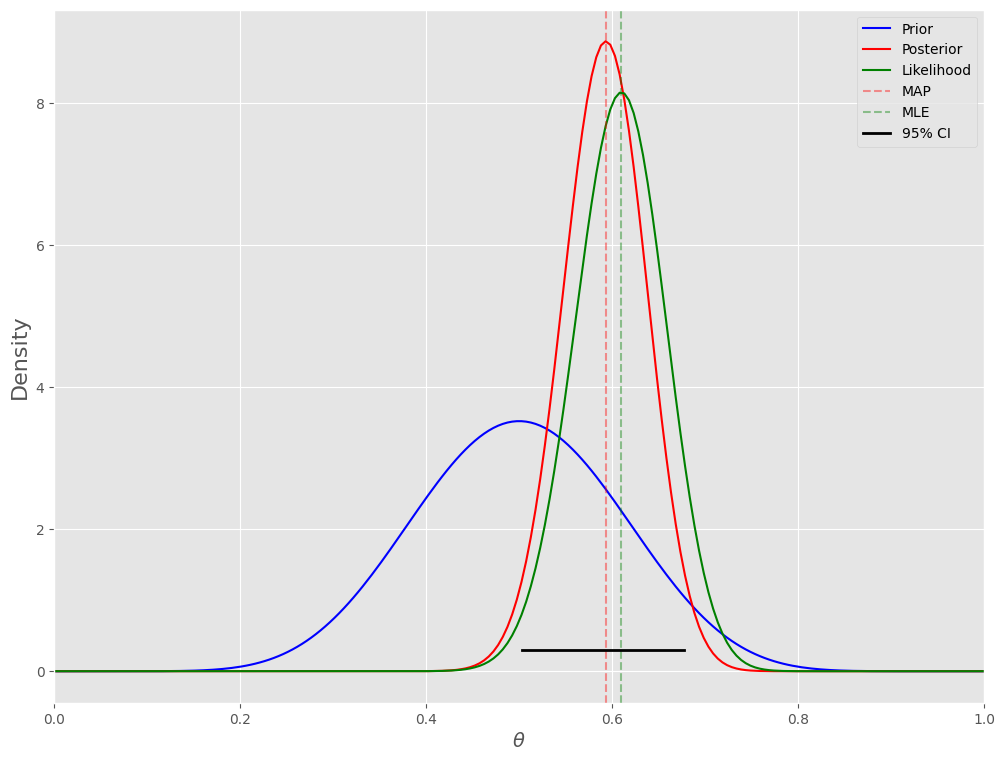

In [4]:
n = 100
h = 61
p = h/n
rv = st.binom(n, p)
mu = rv.mean()

a, b = 10, 10
prior = st.beta(a, b)
post = st.beta(h+a, n-h+b)
ci = post.interval(0.95)

thetas = np.linspace(0, 1, 200)
plt.figure(figsize=(12, 9))
plt.style.use('ggplot')
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

### Численное решение

100 61


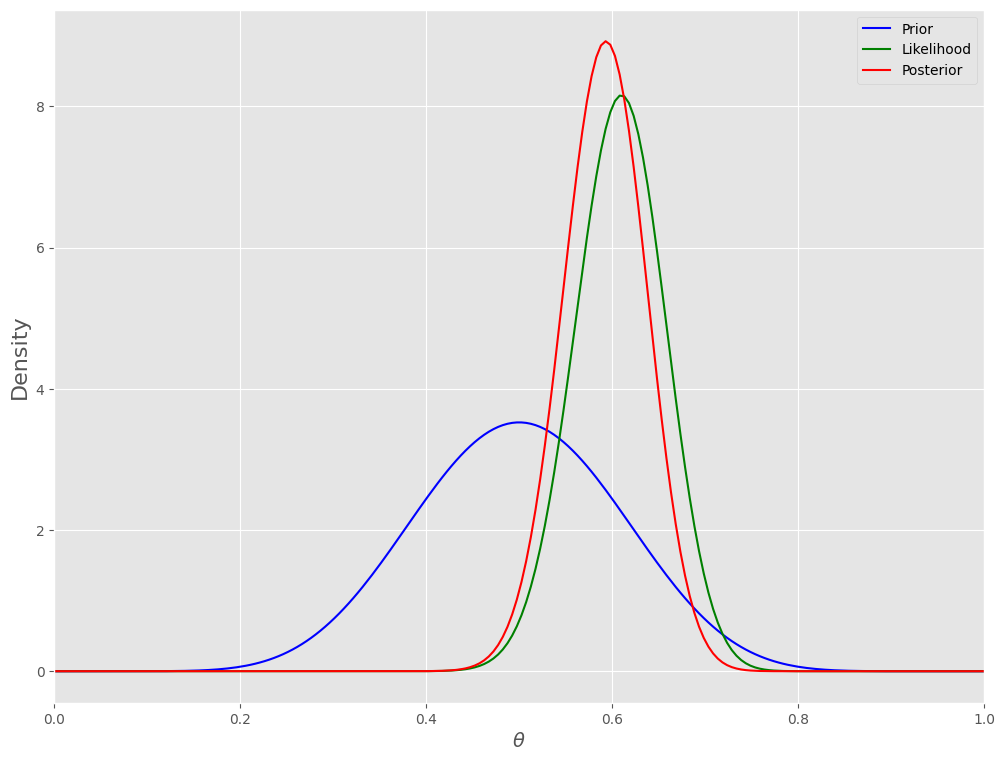

In [5]:

thetas = np.linspace(0, 1, 200)
prior = st.beta(a, b)

post = prior.pdf(thetas) * st.binom(n, thetas).pmf(h)
print(n,h)
post /= (post.sum() / len(thetas))

plt.figure(figsize=(12, 9))
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior', c='red')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

### Алгоритм Метрополиса-Хастингса
Для реализации алгоритма Метрополиса-Гастингса необходимо взять случайные выборки из следующих распределений
- стандартное равномерное распределение
- распределение предложений (proposal distriution) p(x) которое мы выбираем равным N(0,σ)
- целевое распределение g(x) которое пропорционально апостериорной вероятности
Если задано начальное значение для θ с положительной вероятностью, алгоритм Метрополиса-Гастингса работает следующим образом
- Выбирается новое предложенное значение θp такое, что θp=θ+Δθ где Δθ∼N(0,σ)
- Вычислить соотношение

$$ \rho = \frac{g(\theta_p | X) }{g(\theta | X)} $$
где $ g$ - апостериорная вероятность
- Если распределение предложений не является симметричным, то для сохранения детального баланса (обратимости) стационарного распределения необходимо взвесить вероятность принятия, а также рассчитать значение:
$$ \rho = \frac{g(\theta_p | X) p(\theta | \theta_p) }{g(\theta | X)p(\theta_p | \theta)} $$
Поскольку мы берем соотношение, то знаменатель отменяет любое распределение, пропорциональное g  также будет работать - поэтому мы можем использовать
$$ \rho = \frac{p(X | \theta_p ) p(\theta_p) }{p(X | \theta ) p(\theta)} $$

- если ρ≥1 , то зададим θ=θp
- Если ρ<1 то задаем θ=θp  с вероятностью ρ , в противном случае задаем θ=θ  (здесь мы используем стандартное равномерное распределение)
- Повторим предыдущие шаги

После некоторого количества итераций k, выборки θk+1,θk+2,... будут являться выборками из апостериорных распределений. Приведем начальные понятия, которые помогут понять, почему это так:
- Мы принимаем предложенное перемещение на θk+1 всякий раз, когда плотность (ненормализованного) целевого распределения в точке θk+1 больше, чем значение θk - поэтому θ будет чаще встречаться там, где целевое распределение плотнее.
- Если бы мы принимали только значения с большей плотностью, то θ застрял бы в локальной моде целевого распределения, поэтому мы допускаем и случайные перемещения в области с меньшей плотностью - оказывается, что правильная вероятность этого определяется соотношением ρ
- В критерии принятия рассматриваются только коэффициенты целевого распределения, поэтому знаменатель аннулируется и не имеет значения - именно поэтому нам нужны выборки только из распределения, пропорционального апостериорному распределению
- Следовательно, θ будет колебаться таким образом, что будет оказываться в местах, пропорциональных плотности апостериорного распределения - то есть θ это выборка из апостериорного распределения.

Дополнительные замечания:

При использовании метода Metropolis-Hastings могут применяться различные распределения предложений:
- Независимый сэмплер использует распределение предложений, которое не зависит от текущего значения θ. В этом случае распределение предложений должно быть похоже на апостериорное распределение для эффективности, обеспечивая при этом ограничение коэффициента принятия в хвостовой части апостериорного распределения.
- В данном примере используется сэмплер случайного шага, который делает случайный шаг с центром в текущем значении θ. В этом случае, эффективность - это компромисс между малым размером шага с высокой вероятностью принятия и большим размером шага с низкой вероятностью принятия. Заметим, что случайный шаг может потребовать много времени для прохождения узких областей распределения вероятностей. Изменение размера шага (например, масштабирование Σ для многомерного нормального распределения предложений) производится таким образом, чтобы целевая доля предложений была принята. Эта процедура называется настройкой (tuning).

In [3]:
from tqdm import tqdm as tqdm
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
lik = st.binom
prior = st.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in tqdm(range(niters)):
    theta_p = theta + st.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print("Efficiency = ", naccept/niters)

100%|██████████| 10000/10000 [00:20<00:00, 491.82it/s]

Efficiency =  0.19


In [13]:
print(lik)

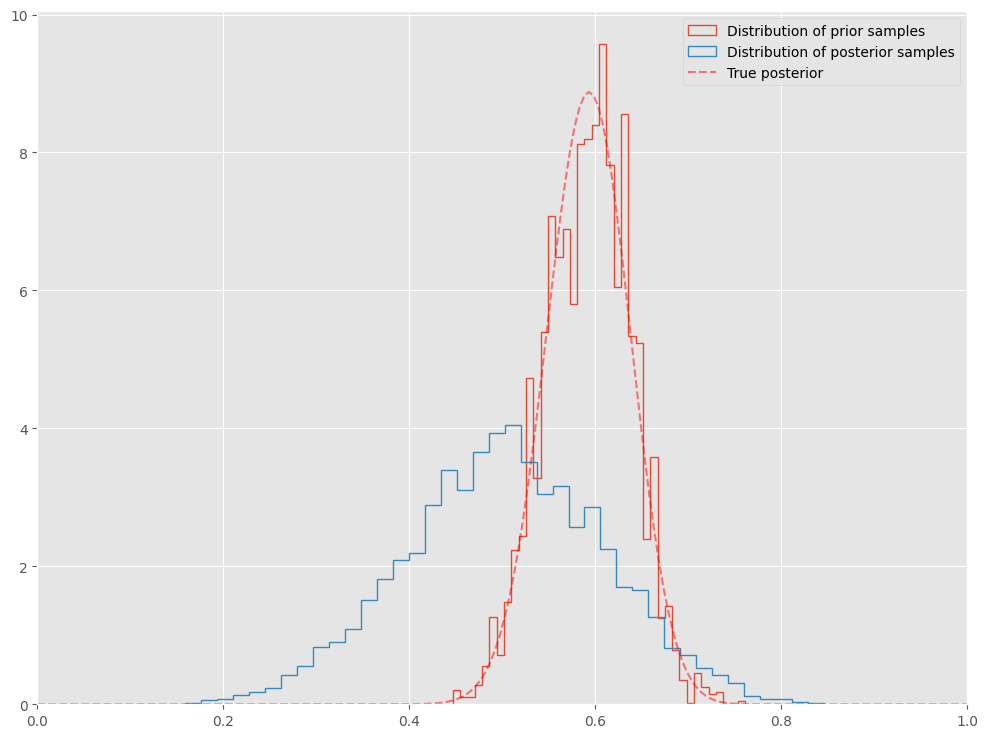

In [15]:
#Efficiency =  0.19
post = st.beta(h+a, n-h+b)

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], 40, histtype='step', density=True, linewidth=1, label='Distribution of prior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', density=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

### Мат ожидание от функции $f(x) = x$ и $f(x) = exp(x^2)$

In [12]:
x_fun = lambda x:x
exp_fun = lambda x: np.exp(x**2)

Ex = np.mean(x_fun(samples[nmcmc:]))
Eexp = np.mean(exp_fun(samples[nmcmc:]))
print(Ex)
print(Eexp)

0.5922200349849034
1.42499631033031
